Bachelor thesis - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling and transformation
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [14]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pyclustertend import hopkins

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

import time

### Load Data

In [15]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [16]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [17]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [18]:
# select features
# to run on sample set True otherwise run on whole data set
if (False):
    dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
    df = dfa.sample(n=70000, random_state=1).copy()
else:
    df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60

# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (True):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,0,-0.258819,-0.965926,0.000000,1.000000
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,0,-0.258819,-0.965926,0.000000,1.000000
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,0,-0.258819,-0.965926,0.000000,1.000000
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,0,-0.258819,-0.965926,0.000000,1.000000
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,0,-0.258819,-0.965926,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
404858,YmlrZTo6dGllcjo6YTFlMmYzZjEtNjkyZS00NjA4LWE5YT...,scooter,179,382,10.000000,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404859,YmlrZTo6dGllcjo6OGUxYjAwNDUtMDY3NS00Mzc4LTk3Yz...,scooter,3602,4204,15.033333,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404860,YmlrZTo6dGllcjo6ZGE1NmNkMDgtN2Q5ZS00YzE0LWI2OT...,scooter,2007,3149,15.033333,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404861,YmlrZTo6dGllcjo6NzRlY2JjZTYtZWQ3Yi00ZGY3LWJmMG...,scooter,2801,2958,5.000000,23,5,1,-0.258819,0.965926,-0.974928,-0.222521


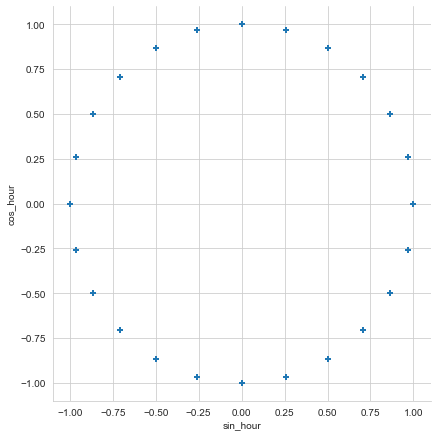

In [19]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

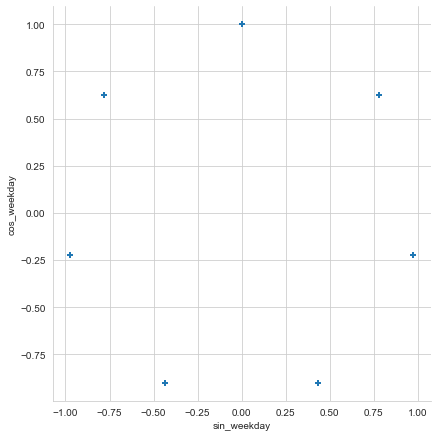

In [20]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

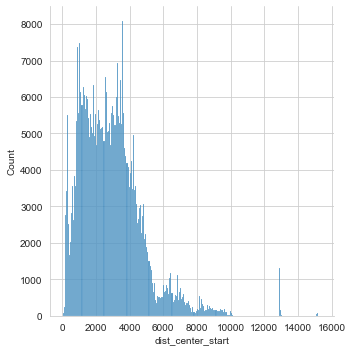

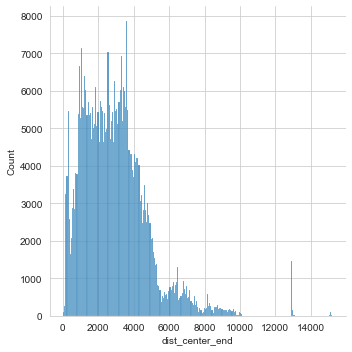

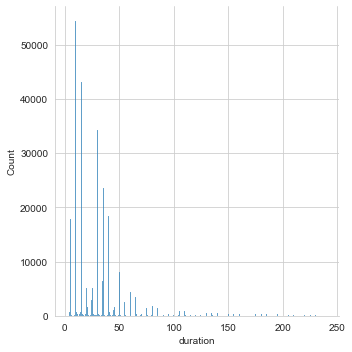

In [21]:
# univariate distribution of numeric variables
for column in df[['dist_center_start','dist_center_end', 'duration']].columns:
    sns.displot(df, x=column)

404863
401622


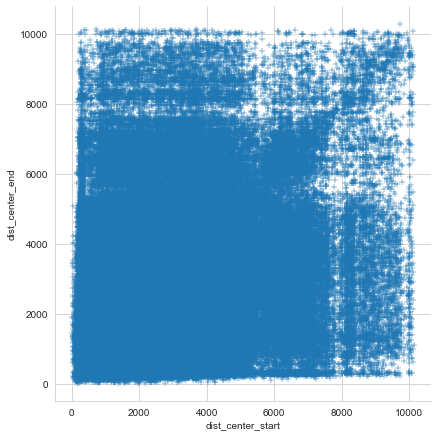

In [27]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
print(len(df))
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)
print(len(df))
# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

In [26]:
df.isnull().any()


id                   False
vehicleType          False
dist_center_start    False
dist_center_end      False
duration             False
hour                 False
weekday              False
weekend              False
sin_hour             False
cos_hour             False
sin_weekday          False
cos_weekday          False
dtype: bool

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekday'),
  Text(5, 0, 'weekend'),
  Text(6, 0, 'sin_hour'),
  Text(7, 0, 'cos_hour'),
  Text(8, 0, 'sin_weekday'),
  Text(9, 0, 'cos_weekday')])

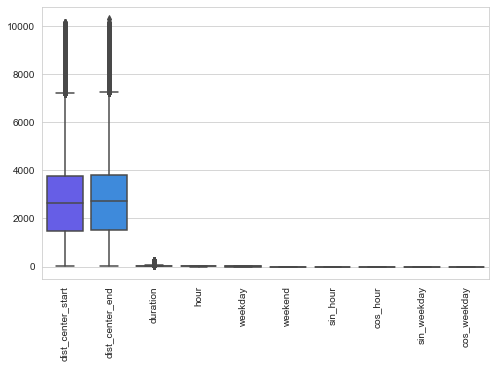

In [11]:
# look at feature scale
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)

In [12]:
# normalize features to get same range as sin and cos values
dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.5
feature_weight2 = 1.8

scaled_df['duration'] = scaled_df['duration'] * feature_weight2
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

scaled_df['sin_weekday'] = scaled_df['sin_weekday'] / 1.5
scaled_df['cos_weekday'] = scaled_df['cos_weekday'] / 1.5

scaled_df['weekend'] = scaled_df['weekend'] / 1.5

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.513469
cos_hour             0.384401
sin_weekday          0.223663
cos_weekday          0.218842
dist_center_start    0.548566
dist_center_end      0.551122
duration             0.510852
weekend              0.147749
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'dist_center_start'),
  Text(5, 0, 'dist_center_end'),
  Text(6, 0, 'duration'),
  Text(7, 0, 'weekend')])

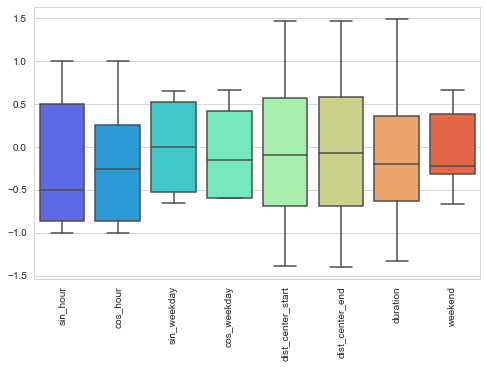

In [13]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

### Cluster tendency

In [29]:
# calculate hopkins statistics on subset (5% of data)
subset5perc = int(len(scaled_df) * 0.05)
hopkins(scaled_df, subset5perc)

0.09533642118622443

### Clustering trip types via k-means 

#### Parameter selection / clustering performance evaluation

In [15]:
# run k-means multiple times to identify "optimal" k

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

# select range max value for for-loop
max_num_cluster = 30

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  1020597.7912438184
silhouette:  0.17365566052454354
calinski harabasz:  88104.86493394928
davies bouldin:  2.1090100057294605
3453.2009797096252
3
inertia:  913063.7236747855
silhouette:  0.16621980136613365
calinski harabasz:  72890.88560031676
davies bouldin:  2.028075938596943
2468.070759534836
4
inertia:  826442.2241729146
silhouette:  0.15498184416630628
calinski harabasz:  67718.53435646281
davies bouldin:  1.9136938100563963
2956.496991634369
5
inertia:  760841.6845937768
silhouette:  0.15912374152868214
calinski harabasz:  63824.83257591992
davies bouldin:  1.8660152447307077
2882.625198364258
6
inertia:  711128.1375586682
silhouette:  0.16351938296228832
calinski harabasz:  60244.197153914596
davies bouldin:  1.768434493704248
2576.080969810486
7
inertia:  669148.1072118955
silhouette:  0.16479870165199376
calinski harabasz:  57552.53490939873
davies bouldin:  1.7009714872479016
2508.6699438095093
8
inertia:  634226.1987389014
silhouette:  0.17294701912588556
calin

#### Elbow method

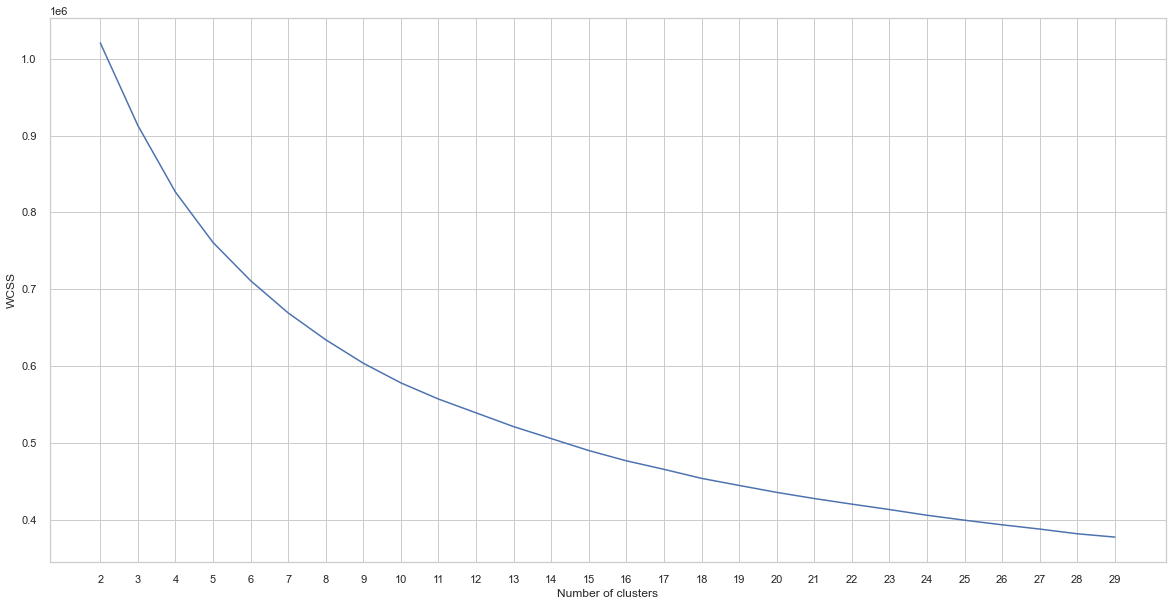

In [57]:
# plot wcss for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
#fig.savefig('elbowPlot2.png', dpi=fig.dpi)

#### Silhouette coefficient

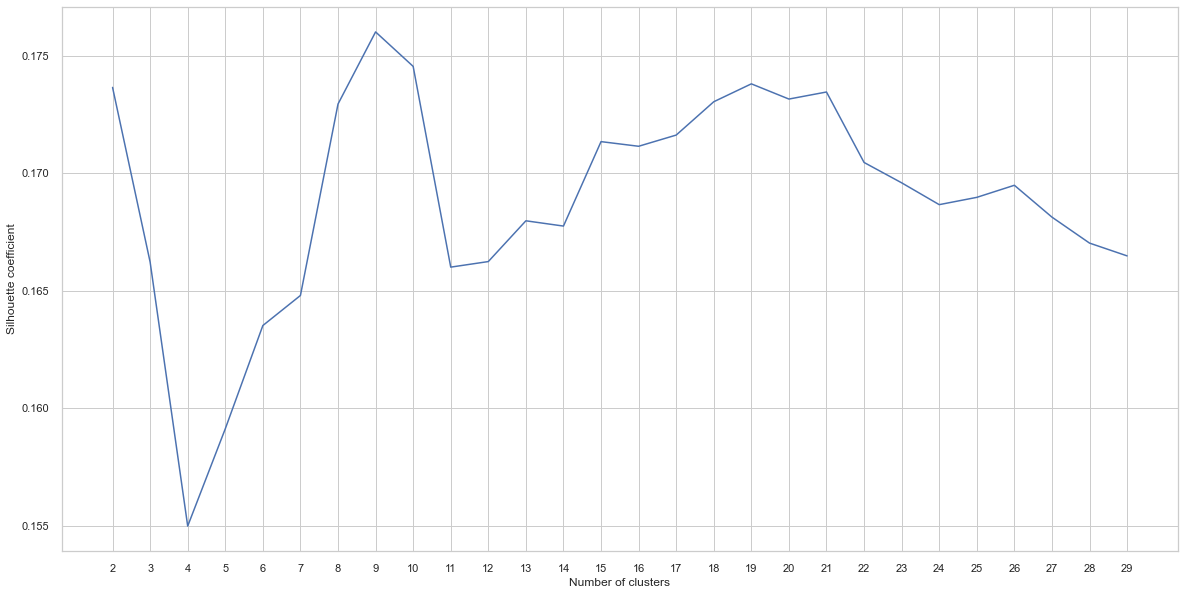

In [55]:
# plot silhouette coefficients for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()
#fig.savefig('silhouetteScore2.png', dpi=fig.dpi)

#### Calinski Harabasz score

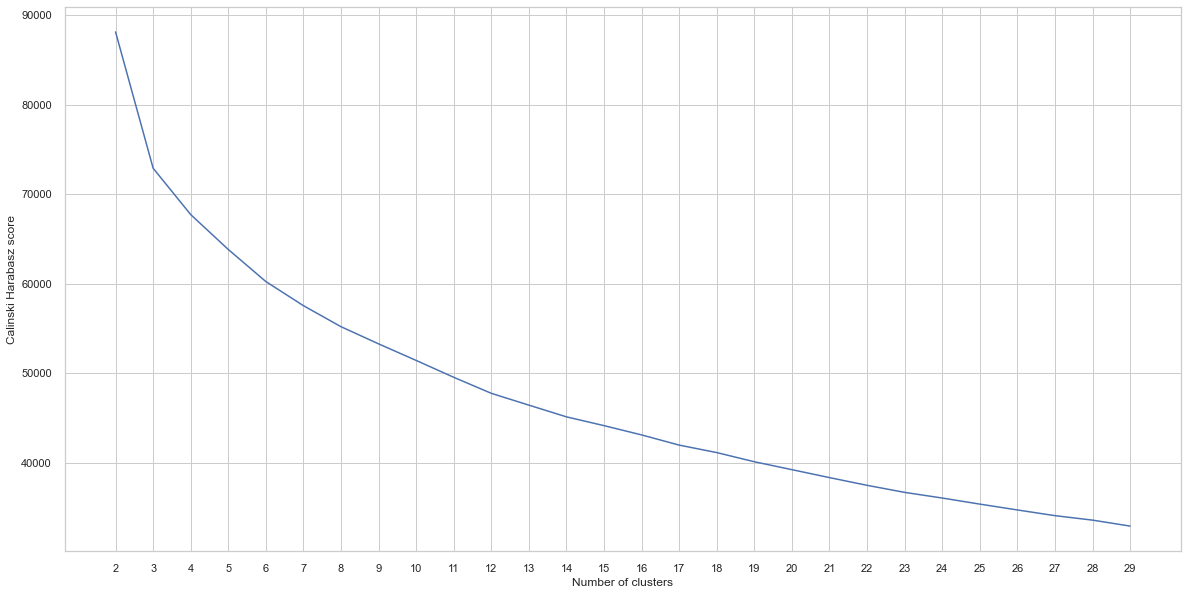

In [53]:
# plot Calinski Harabasz score for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()
#fig.savefig('calinskiHarabaszScore2.png', dpi=fig.dpi)

#### Davies Bouldin index

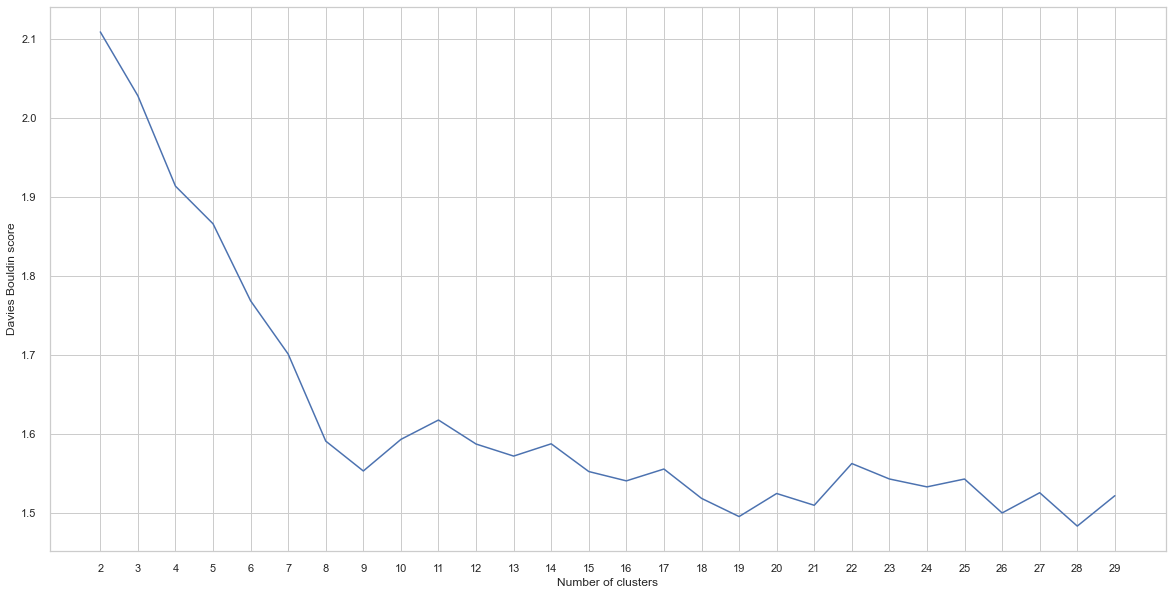

In [51]:
# plot Davies Bouldin scores for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()
#fig.savefig('daviesBouldinScore2.png', dpi=fig.dpi)

#### K-means with selected parameter

In [18]:
# cluster data for the chosen number of clusters
k = 19

# run k-means
kmeans = KMeans(n_clusters=k,  n_init=100, max_iter=5000, random_state=0).fit(scaled_df)

# create dataframe of trips with cluster column
clustered_data = df.copy()
cluster_labels = kmeans.fit_predict(scaled_df)
clustered_data['cluster'] = cluster_labels
scaled_df['cluster'] = cluster_labels

clustered_data.head()

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,0,-0.258819,-0.965926,0.0,1.0,7
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,0,-0.258819,-0.965926,0.0,1.0,0
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,0,-0.258819,-0.965926,0.0,1.0,3
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,0,-0.258819,-0.965926,0.0,1.0,16
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,0,-0.258819,-0.965926,0.0,1.0,7


### Interpretation of results

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

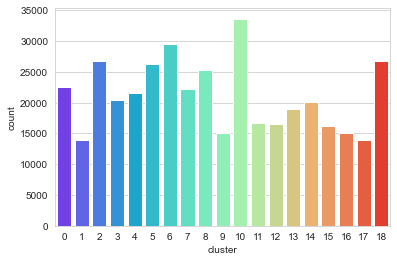

In [19]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Attribute table

In [20]:
# create an attribute table to interpret cluster results
# create table with cardinality columns
cluster_cardinality = clustered_data.groupby(['cluster']).count().iloc[:,:2].copy()
cluster_cardinality.columns = ['cardinality', 'proportion']
instances = len(clustered_data)
cluster_cardinality['proportion'] = cluster_cardinality['cardinality'] / instances * 100
interpret_df = cluster_cardinality

# create table with means of numeric features
means = clustered_data[['dist_center_start', 'dist_center_end', 'duration', 'weekend', 'cluster']].copy()
means = means.groupby(['cluster']).mean()

# merge 2 dataframes
interpret_df = interpret_df.join(means)

# create table with percentages for each categorical value
time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

# merge dataframes
interpret_df = interpret_df.join(time_df)

# save files set True
if (False):
    interpret_df.T.round(2).to_excel("Final-19-15-18-15-15-InterpretClusters.xlsx")  
    interpret_df.to_csv('finalclusters.csv', index=False)
    scaled_df.to_csv('scaledDataWithFinalClusters.csv', index=False)

# display whole dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret_df.T.round(2)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cardinality,22468.00,13905.00,26729.00,20341.00,21605.00,26312.00,29528.00,22236.00,25303.00,15093.00,33597.00,16740.00,16551.00,18937.00,20157.00,16219.00,15101.00,13990.00,26810.00
proportion,5.59,3.46,6.66,5.06,5.38,6.55,7.35,5.54,6.30,3.76,8.37,4.17,4.12,4.72,5.02,4.04,3.76,3.48,6.68
dist_center_start,1546.36,4297.65,1696.50,1770.85,3100.97,3100.59,4407.58,4608.85,1645.38,2703.65,1732.20,2434.51,1942.14,5548.23,2361.23,4325.93,4352.16,2854.80,1529.74
dist_center_end,1694.20,4161.15,1591.49,4647.39,3244.66,2926.54,1536.53,4402.89,1571.21,5463.45,1655.44,2893.75,4601.31,2551.05,2425.33,4157.87,4865.70,3048.96,1701.42
duration,16.34,18.16,17.08,32.52,24.51,81.30,33.02,20.14,21.17,37.66,17.01,17.30,27.84,35.14,23.14,18.55,23.39,98.18,16.15
weekend,0.01,0.11,0.03,0.10,1.00,0.20,0.14,0.17,1.00,0.14,0.01,0.88,0.04,0.17,0.99,0.05,0.27,0.20,0.11
0 Monday,18.67,16.34,0.00,18.48,0.14,14.80,16.13,16.68,0.02,15.56,31.41,3.82,15.56,13.99,0.16,16.92,13.48,14.49,17.05
1 Tuesday,19.47,19.09,0.00,16.94,0.00,14.79,16.71,16.26,0.00,17.58,33.69,0.27,17.07,13.97,0.00,18.47,13.53,16.00,19.55
2 Wednesday,18.52,17.99,0.00,16.77,0.00,14.28,16.41,15.66,0.00,16.87,33.78,0.03,19.20,15.61,0.00,19.79,11.95,14.59,16.85
3 Thursday,19.15,18.46,41.99,17.12,0.00,15.38,18.28,15.60,0.00,18.45,0.00,0.24,19.79,16.24,0.00,18.64,14.91,16.35,18.72


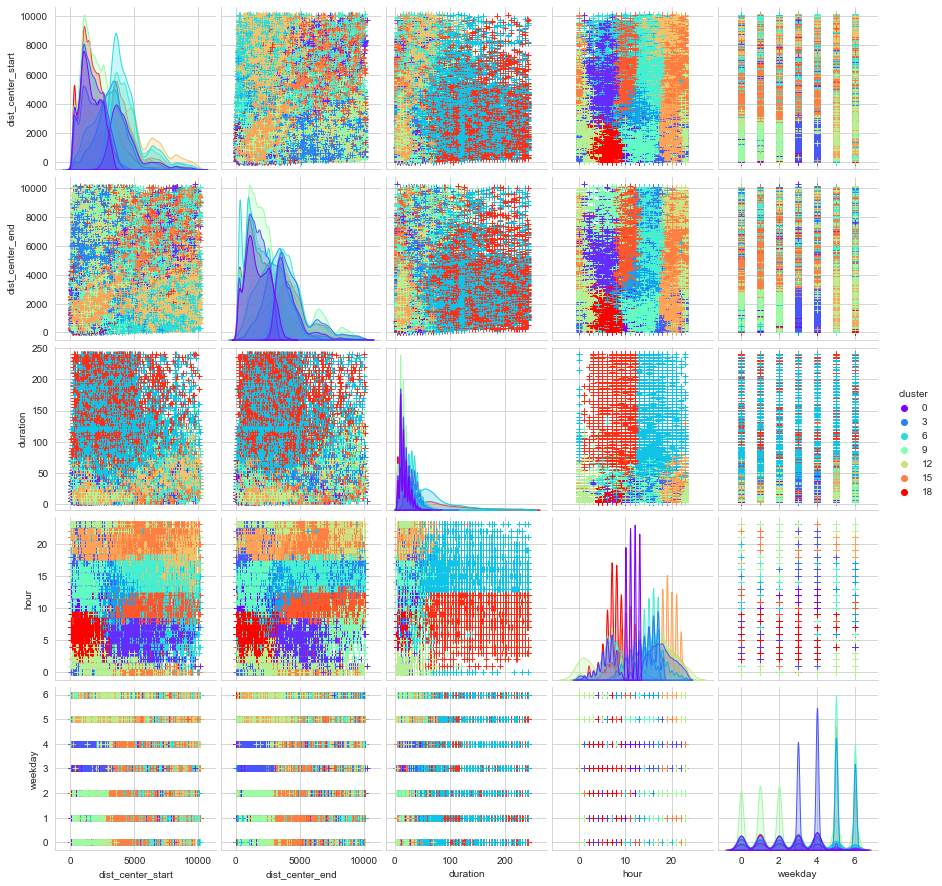

In [21]:
# show pairwise relation
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','weekday','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow')

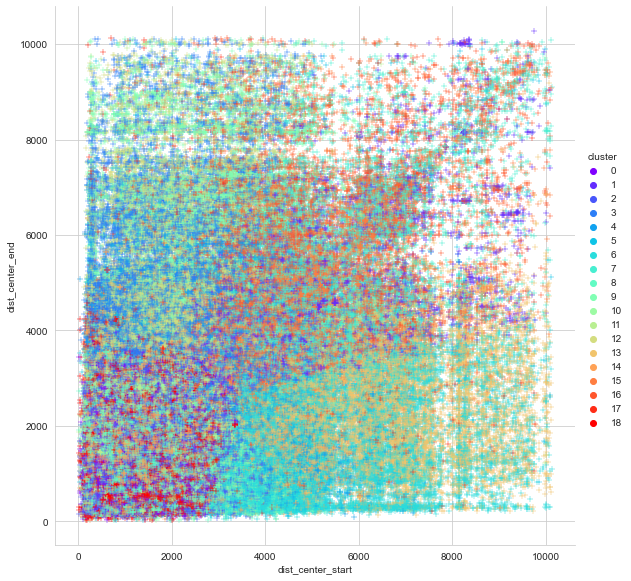

In [22]:
# plot cluster results for two desired features
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

#### Cluster visualization with t-SNE

In [28]:
tSNE_data = pd.read_csv('scaledDataWithFinalClusters.csv')
trip_type_transform = {0:0, 1:0}
tSNE_data.head()

,sin_hour,cos_hour,sin_weekday,cos_weekday,dist_center_start,dist_center_end,duration,weekend,cluster
0,-0.258819,-0.965926,0.0,0.666667,0.988174,0.851393,-0.668495,-0.216962,12
1,-0.258819,-0.965926,0.0,0.666667,-1.075801,-0.874320,-0.334291,-0.222495,10
2,-0.258819,-0.965926,0.0,0.666667,-0.484998,1.192790,-0.448967,-0.298820,18
3,-0.258819,-0.965926,0.0,0.666667,0.109899,0.900670,-0.368534,-0.513020,8
4,-0.258819,-0.965926,0.0,0.666667,1.356669,-0.095530,-0.195215,-0.271751,12


In [74]:
#TSNE_data = scaled_df.copy()
#sampleTSNE = TSNE_data.sample(n=40000, random_state=1).reset_index()
sampleTSNE = scaled_df.copy()
# cluster data for the chosen number of clusters
#k = 19
#k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
#clusters = k_means_new.fit_predict(sampleTSNE)
#sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,1:-1]

##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 401622 samples in 1.625s...
[t-SNE] Computed neighbors for 401622 samples in 128.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 401622
[t-SNE] Computed conditional probabilities for sample 2000 / 401622
[t-SNE] Computed conditional probabilities for sample 3000 / 401622
[t-SNE] Computed conditional probabilities for sample 4000 / 401622
[t-SNE] Computed conditional probabilities for sample 5000 / 401622
[t-SNE] Computed conditional probabilities for sample 6000 / 401622
[t-SNE] Computed conditional probabilities for sample 7000 / 401622
[t-SNE] Computed conditional probabilities for sample 8000 / 401622
[t-SNE] Computed conditional probabilities for sample 9000 / 401622
[t-SNE] Computed conditional probabilities for sample 10000 / 401622
[t-SNE] Computed conditional probabilities for sample 11000 / 401622
[t-SNE] Computed conditional probabilities for sample 12000 / 401622
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 120000 / 401622
[t-SNE] Computed conditional probabilities for sample 121000 / 401622
[t-SNE] Computed conditional probabilities for sample 122000 / 401622
[t-SNE] Computed conditional probabilities for sample 123000 / 401622
[t-SNE] Computed conditional probabilities for sample 124000 / 401622
[t-SNE] Computed conditional probabilities for sample 125000 / 401622
[t-SNE] Computed conditional probabilities for sample 126000 / 401622
[t-SNE] Computed conditional probabilities for sample 127000 / 401622
[t-SNE] Computed conditional probabilities for sample 128000 / 401622
[t-SNE] Computed conditional probabilities for sample 129000 / 401622
[t-SNE] Computed conditional probabilities for sample 130000 / 401622
[t-SNE] Computed conditional probabilities for sample 131000 / 401622
[t-SNE] Computed conditional probabilities for sample 132000 / 401622
[t-SNE] Computed conditional probabilities for sample 133000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 246000 / 401622
[t-SNE] Computed conditional probabilities for sample 247000 / 401622
[t-SNE] Computed conditional probabilities for sample 248000 / 401622
[t-SNE] Computed conditional probabilities for sample 249000 / 401622
[t-SNE] Computed conditional probabilities for sample 250000 / 401622
[t-SNE] Computed conditional probabilities for sample 251000 / 401622
[t-SNE] Computed conditional probabilities for sample 252000 / 401622
[t-SNE] Computed conditional probabilities for sample 253000 / 401622
[t-SNE] Computed conditional probabilities for sample 254000 / 401622
[t-SNE] Computed conditional probabilities for sample 255000 / 401622
[t-SNE] Computed conditional probabilities for sample 256000 / 401622
[t-SNE] Computed conditional probabilities for sample 257000 / 401622
[t-SNE] Computed conditional probabilities for sample 258000 / 401622
[t-SNE] Computed conditional probabilities for sample 259000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 364000 / 401622
[t-SNE] Computed conditional probabilities for sample 365000 / 401622
[t-SNE] Computed conditional probabilities for sample 366000 / 401622
[t-SNE] Computed conditional probabilities for sample 367000 / 401622
[t-SNE] Computed conditional probabilities for sample 368000 / 401622
[t-SNE] Computed conditional probabilities for sample 369000 / 401622
[t-SNE] Computed conditional probabilities for sample 370000 / 401622
[t-SNE] Computed conditional probabilities for sample 371000 / 401622
[t-SNE] Computed conditional probabilities for sample 372000 / 401622
[t-SNE] Computed conditional probabilities for sample 373000 / 401622
[t-SNE] Computed conditional probabilities for sample 374000 / 401622
[t-SNE] Computed conditional probabilities for sample 375000 / 401622
[t-SNE] Computed conditional probabilities for sample 376000 / 401622
[t-SNE] Computed conditional probabilities for sample 377000 / 401622
[t-SNE] Computed con

array([[106.29852 ,  12.080965],
       [ 81.82028 ,  74.16445 ],
       [113.04526 ,  74.48475 ],
       ...,
       [ 72.80047 , -22.332369],
       [ 79.800156, -98.619934],
       [ 70.60539 , -28.039436]], dtype=float32)

In [75]:
cluster_label_tsne = sampleTSNE['cluster']

tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = cluster_label_tsne
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster.columns = ['x1','x2','cluster']
tsne_cluster.head()
#sampleTSNE['cluster']


,x1,x2,cluster
0,106.298523,12.080965,0
1,81.820282,74.164452,6
2,113.045258,74.484749,5
3,116.566971,70.106277,11
4,105.009842,-8.774091,0


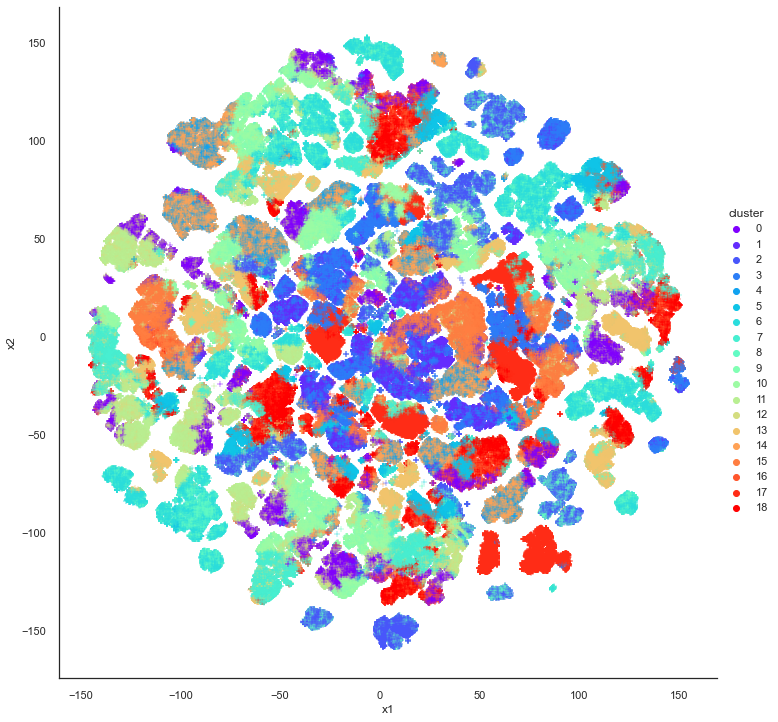

In [76]:
sns.set_theme(style="white")

sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

In [91]:
#TSNE_data2 = scaled_df.copy()
#sampleTSNE2 = TSNE_data2.sample(n=40000, random_state=1).reset_index()
sampleTSNE2 = scaled_df.copy()
# cluster data for the chosen number of clusters
#k = 19
#k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
#clusters = k_means_new.fit_predict(sampleTSNE)
#sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X2 = sampleTSNE2.iloc[:,1:-1]

##########################################
tsne2 = TSNE(n_components=2, perplexity=30.0, n_iter=5000, verbose=1).fit_transform(X2)

tsne2

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 401622 samples in 1.575s...
[t-SNE] Computed neighbors for 401622 samples in 41.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 401622
[t-SNE] Computed conditional probabilities for sample 2000 / 401622
[t-SNE] Computed conditional probabilities for sample 3000 / 401622
[t-SNE] Computed conditional probabilities for sample 4000 / 401622
[t-SNE] Computed conditional probabilities for sample 5000 / 401622
[t-SNE] Computed conditional probabilities for sample 6000 / 401622
[t-SNE] Computed conditional probabilities for sample 7000 / 401622
[t-SNE] Computed conditional probabilities for sample 8000 / 401622
[t-SNE] Computed conditional probabilities for sample 9000 / 401622
[t-SNE] Computed conditional probabilities for sample 10000 / 401622
[t-SNE] Computed conditional probabilities for sample 11000 / 401622
[t-SNE] Computed conditional probabilities for sample 12000 / 401622
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 120000 / 401622
[t-SNE] Computed conditional probabilities for sample 121000 / 401622
[t-SNE] Computed conditional probabilities for sample 122000 / 401622
[t-SNE] Computed conditional probabilities for sample 123000 / 401622
[t-SNE] Computed conditional probabilities for sample 124000 / 401622
[t-SNE] Computed conditional probabilities for sample 125000 / 401622
[t-SNE] Computed conditional probabilities for sample 126000 / 401622
[t-SNE] Computed conditional probabilities for sample 127000 / 401622
[t-SNE] Computed conditional probabilities for sample 128000 / 401622
[t-SNE] Computed conditional probabilities for sample 129000 / 401622
[t-SNE] Computed conditional probabilities for sample 130000 / 401622
[t-SNE] Computed conditional probabilities for sample 131000 / 401622
[t-SNE] Computed conditional probabilities for sample 132000 / 401622
[t-SNE] Computed conditional probabilities for sample 133000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 239000 / 401622
[t-SNE] Computed conditional probabilities for sample 240000 / 401622
[t-SNE] Computed conditional probabilities for sample 241000 / 401622
[t-SNE] Computed conditional probabilities for sample 242000 / 401622
[t-SNE] Computed conditional probabilities for sample 243000 / 401622
[t-SNE] Computed conditional probabilities for sample 244000 / 401622
[t-SNE] Computed conditional probabilities for sample 245000 / 401622
[t-SNE] Computed conditional probabilities for sample 246000 / 401622
[t-SNE] Computed conditional probabilities for sample 247000 / 401622
[t-SNE] Computed conditional probabilities for sample 248000 / 401622
[t-SNE] Computed conditional probabilities for sample 249000 / 401622
[t-SNE] Computed conditional probabilities for sample 250000 / 401622
[t-SNE] Computed conditional probabilities for sample 251000 / 401622
[t-SNE] Computed conditional probabilities for sample 252000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 365000 / 401622
[t-SNE] Computed conditional probabilities for sample 366000 / 401622
[t-SNE] Computed conditional probabilities for sample 367000 / 401622
[t-SNE] Computed conditional probabilities for sample 368000 / 401622
[t-SNE] Computed conditional probabilities for sample 369000 / 401622
[t-SNE] Computed conditional probabilities for sample 370000 / 401622
[t-SNE] Computed conditional probabilities for sample 371000 / 401622
[t-SNE] Computed conditional probabilities for sample 372000 / 401622
[t-SNE] Computed conditional probabilities for sample 373000 / 401622
[t-SNE] Computed conditional probabilities for sample 374000 / 401622
[t-SNE] Computed conditional probabilities for sample 375000 / 401622
[t-SNE] Computed conditional probabilities for sample 376000 / 401622
[t-SNE] Computed conditional probabilities for sample 377000 / 401622
[t-SNE] Computed conditional probabilities for sample 378000 / 401622
[t-SNE] Computed con

MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: could not allocate 131072000 bytes

Exception ignored in: 'sklearn.neighbors._quad_tree._QuadTree._insert_point_in_new_child'
Traceback (most recent call last):
  File "sklearn\neighbors\_quad_tree.pyx", line 586, in sklearn.neighbors._quad_tree._QuadTree._resize
  File "sklearn\neighbors\_quad_tree.pyx", line 606, in sklearn.neighbors._quad_tree._QuadTree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 131072000 bytes


MemoryError: Unable to allocate 331. MiB for an array with shape (43323188,) and data type int64

In [ ]:
cluster_label_tsne2 = sampleTSNE2['cluster']

tsne_cluster2 = pd.DataFrame(tsne2)
tsne_cluster2['cluster'] = cluster_label_tsne2
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster2.columns = ['x1','x2','cluster']
tsne_cluster2.head()
#sampleTSNE['cluster']

In [ ]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster2, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

In [86]:
#TSNE_data3 = scaled_df.copy()
#sampleTSNE3 = TSNE_data3.sample(n=40000, random_state=1).reset_index()
sampleTSNE3 = scaled_df.copy()


from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X3 = sampleTSNE3.iloc[:,1:-1]

##########################################
tsne3 = TSNE(n_components=2, perplexity=50.0, n_iter=5000, verbose=1).fit_transform(X3)

tsne3

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 401622 samples in 1.886s...
[t-SNE] Computed neighbors for 401622 samples in 69.599s...
[t-SNE] Computed conditional probabilities for sample 1000 / 401622
[t-SNE] Computed conditional probabilities for sample 2000 / 401622
[t-SNE] Computed conditional probabilities for sample 3000 / 401622
[t-SNE] Computed conditional probabilities for sample 4000 / 401622
[t-SNE] Computed conditional probabilities for sample 5000 / 401622
[t-SNE] Computed conditional probabilities for sample 6000 / 401622
[t-SNE] Computed conditional probabilities for sample 7000 / 401622
[t-SNE] Computed conditional probabilities for sample 8000 / 401622
[t-SNE] Computed conditional probabilities for sample 9000 / 401622
[t-SNE] Computed conditional probabilities for sample 10000 / 401622
[t-SNE] Computed conditional probabilities for sample 11000 / 401622
[t-SNE] Computed conditional probabilities for sample 12000 / 401622
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 118000 / 401622
[t-SNE] Computed conditional probabilities for sample 119000 / 401622
[t-SNE] Computed conditional probabilities for sample 120000 / 401622
[t-SNE] Computed conditional probabilities for sample 121000 / 401622
[t-SNE] Computed conditional probabilities for sample 122000 / 401622
[t-SNE] Computed conditional probabilities for sample 123000 / 401622
[t-SNE] Computed conditional probabilities for sample 124000 / 401622
[t-SNE] Computed conditional probabilities for sample 125000 / 401622
[t-SNE] Computed conditional probabilities for sample 126000 / 401622
[t-SNE] Computed conditional probabilities for sample 127000 / 401622
[t-SNE] Computed conditional probabilities for sample 128000 / 401622
[t-SNE] Computed conditional probabilities for sample 129000 / 401622
[t-SNE] Computed conditional probabilities for sample 130000 / 401622
[t-SNE] Computed conditional probabilities for sample 131000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 236000 / 401622
[t-SNE] Computed conditional probabilities for sample 237000 / 401622
[t-SNE] Computed conditional probabilities for sample 238000 / 401622
[t-SNE] Computed conditional probabilities for sample 239000 / 401622
[t-SNE] Computed conditional probabilities for sample 240000 / 401622
[t-SNE] Computed conditional probabilities for sample 241000 / 401622
[t-SNE] Computed conditional probabilities for sample 242000 / 401622
[t-SNE] Computed conditional probabilities for sample 243000 / 401622
[t-SNE] Computed conditional probabilities for sample 244000 / 401622
[t-SNE] Computed conditional probabilities for sample 245000 / 401622
[t-SNE] Computed conditional probabilities for sample 246000 / 401622
[t-SNE] Computed conditional probabilities for sample 247000 / 401622
[t-SNE] Computed conditional probabilities for sample 248000 / 401622
[t-SNE] Computed conditional probabilities for sample 249000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 356000 / 401622
[t-SNE] Computed conditional probabilities for sample 357000 / 401622
[t-SNE] Computed conditional probabilities for sample 358000 / 401622
[t-SNE] Computed conditional probabilities for sample 359000 / 401622
[t-SNE] Computed conditional probabilities for sample 360000 / 401622
[t-SNE] Computed conditional probabilities for sample 361000 / 401622
[t-SNE] Computed conditional probabilities for sample 362000 / 401622
[t-SNE] Computed conditional probabilities for sample 363000 / 401622
[t-SNE] Computed conditional probabilities for sample 364000 / 401622
[t-SNE] Computed conditional probabilities for sample 365000 / 401622
[t-SNE] Computed conditional probabilities for sample 366000 / 401622
[t-SNE] Computed conditional probabilities for sample 367000 / 401622
[t-SNE] Computed conditional probabilities for sample 368000 / 401622
[t-SNE] Computed conditional probabilities for sample 369000 / 401622
[t-SNE] Computed con

array([[ 123.641815 ,  -41.149055 ],
       [-161.95703  ,   15.340228 ],
       [   4.7389526,   77.30574  ],
       ...,
       [ -43.682083 ,   53.68488  ],
       [-112.53423  ,   11.793158 ],
       [ -38.359024 ,   56.592514 ]], dtype=float32)

In [87]:
cluster_label_tsne3 = sampleTSNE3['cluster']

tsne_cluster3 = pd.DataFrame(tsne3)
tsne_cluster3['cluster'] = cluster_label_tsne3
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster3.columns = ['x1','x2','cluster']
tsne_cluster3.head()
#sampleTSNE['cluster']

,x1,x2,cluster
0,123.641815,-41.149055,0
1,-161.957031,15.340228,6
2,4.738953,77.305740,5
3,6.759074,73.844200,11
4,7.588920,-22.451591,0


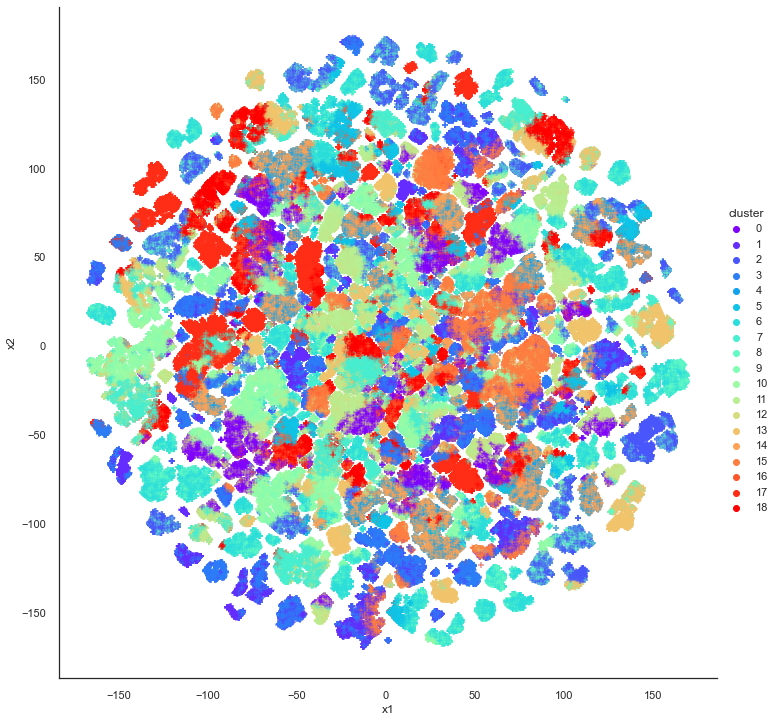

In [88]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster3, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

#### Radar plot

In [89]:
#clustered_data.groupby(['cluster']).describe()

### Distribution of trip types within mobility modes

In [134]:
# show distribution of each mobility mode for the identified trip types
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution {} [%]'.format(mode)] = distribution['id'] / trip_volume *100

    return distribution[['Distribution {} [%]'.format(mode)]]

In [143]:
car = create_distribution_overview('car')
bicycle = create_distribution_overview('bicycle')
scooter = create_distribution_overview('scooter')
df_distribution = car.merge(bicycle, how='left', on='cluster')
df_distribution = df_distribution.merge(scooter, how='left', on='cluster')
df_distribution

,Distribution car [%],Distribution bicycle [%],Distribution scooter [%]
cluster,,,
0,7.469351,1.490138,1.266220
1,4.816846,6.925219,8.221461
2,2.478367,7.584016,9.292591
3,4.946830,7.509509,9.815075
4,5.996195,3.776322,0.408121
5,5.588911,2.431277,1.104018
6,2.997479,11.803459,12.235394
7,5.031423,3.282224,5.090295
8,3.465009,11.164268,13.500120
